In [353]:
import re 
import pandas as pd  
import numpy as np
from time import time  
import torch
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import defaultdict  
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, Embedding, MaxPooling1D, Flatten,GlobalMaxPooling1D,GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
import spacy  

import logging  
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## 1. Read data

In [170]:
# read train data
train_data=pd.read_csv("train.csv")
# read test data
test_data=pd.read_csv("test.csv")

In [171]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [172]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [255]:
voca_train=train_data.drop(['target'],axis=1)
voca=pd.concat([voca_train,test_data])
voca

,id,keyword,location,text
0,1,,,Our Deeds are the Reason of this #earthquake M...
1,4,,,Forest fire near La Ronge Sask. Canada
2,5,,,All residents asked to 'shelter in place' are ...
3,6,,,"13,000 people receive #wildfires evacuation or..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...
3258,10861,,,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,,,Storm in RI worse than last hurricane. My city...
3260,10868,,,Green Line derailment in Chicago http://t.co/U...
3261,10874,,,MEG issues Hazardous Weather Outlook (HWO) htt...


## 2. Preprocessing

In [294]:
def join_col_test(data:pd.DataFrame):
    text=[]
    id=[]
    for index, row in data.iterrows():
        x=str(row["keyword"])+" " + str(row["location"]) + " " + row["text"]
        text.append(x)
        id.append(row['id'])
    return {'id':id,'text':text}

In [295]:
def join_col_train(data:pd.DataFrame):
    text=[]
    label=[]
    for index, row in data.iterrows():
        x=str(row["keyword"])+" " + str(row["location"]) + " " + row["text"]
        text.append(x)
        label.append(row['target'])
    return {'text':text,'label':label}

In [296]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    stops = stopwords.words('english')
    #print(stops)
    porter = PorterStemmer()
    for word in sentence.split():
        if word in stops:
            sentence = sentence.replace(word, '')
        sentence = sentence.replace(word, porter.stem(word))
    return sentence.lower()

In [297]:
# Convert NaN values ​​to empty strings
train_data=train_data.fillna("")
test_data=test_data.fillna("")
voca=voca.fillna("")

In [316]:
new_train_data=pd.DataFrame(join_col_train(train_data))
new_test_data=pd.DataFrame(join_col_test(test_data))
new_voca=pd.DataFrame(join_col_test(voca))

In [317]:
new_test_data['text']=new_test_data['text'].apply(preprocess_text)
new_train_data['text']=new_train_data['text'].apply(preprocess_text)
new_voca['text']=new_voca['text'].apply(preprocess_text)

In [318]:
X_train, X_valid, y_train, y_valid = train_test_split(new_train_data['text'], new_train_data['label'], test_size=0.2, random_state=42)

In [319]:
new_voca=new_voca['text']

## 3. Train word2vec model

In [320]:
from gensim.models import Word2Vec

In [321]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_voca)

In [322]:
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
vocab=tokenizer.texts_to_sequences(new_voca)

In [339]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

28679

In [325]:
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_valid = pad_sequences(X_valid, maxlen=max_length, padding='post')
vocab=pad_sequences(vocab, maxlen=max_length, padding='post')

In [330]:
sentences = [sentence.split() for sentence in new_voca]

In [333]:
w2v_model = Word2Vec(sentences=sentences,
                     min_count=1,
                     window=2,
                     vector_size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=7)

INFO - 22:48:33: collecting all words and their counts
INFO - 22:48:33: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:48:33: PROGRESS: at sentence #10000, processed 145675 words, keeping 27069 word types
INFO - 22:48:33: collected 28678 word types from a corpus of 158523 raw words and 10876 sentences
INFO - 22:48:33: Creating a fresh vocabulary
INFO - 22:48:34: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 28678 unique words (100.00% of original 28678, drops 0)', 'datetime': '2023-05-16T22:48:34.057190', 'gensim': '4.3.1', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
INFO - 22:48:34: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 158523 word corpus (100.00% of original 158523, drops 0)', 'datetime': '2023-05-16T22:48:34.058198', 'gensim': '4.3.1', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13

In [336]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [195]:
print(w2v_model)

Word2Vec<vocab=29005, vector_size=300, alpha=0.03>


## CNN model

In [225]:

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [354]:

keras_model = Sequential()
keras_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))

keras_model.add(GlobalMaxPool1D())
keras_model.add(Dense(10, activation='relu'))
keras_model.add(Dense(1, activation='sigmoid'))
keras_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
keras_model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          2867900   
                                                                 
 global_max_pooling1d_8 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_38 (Dense)            (None, 10)                1010      
                                                                 
 dense_39 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,868,921
Trainable params: 2,868,921
Non-trainable params: 0
_________________________________________________________________


In [361]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Epoch 1/50
96/96 [==============================] - 4s 45ms/step - loss: 0.0056 - accuracy: 0.9975 - val_loss: 0.7088 - val_accuracy: 0.7557
Epoch 2/50
96/96 [==============================] - 4s 46ms/step - loss: 0.0051 - accuracy: 0.9966 - val_loss: 0.6972 - val_accuracy: 0.7584
Epoch 3/50
96/96 [==============================] - 5s 48ms/step - loss: 0.0053 - accuracy: 0.9975 - val_loss: 0.6812 - val_accuracy: 0.7459
Epoch 4/50
96/96 [==============================] - 5s 48ms/step - loss: 0.0049 - accuracy: 0.9975 - val_loss: 0.6861 - val_accuracy: 0.7498
Epoch 5/50
96/96 [==============================] - 4s 47ms/step - loss: 0.0051 - accuracy: 0.9975 - val_loss: 0.6849 - val_accuracy: 0.7479
Epoch 6/50
96/96 [==============================] - 5s 48ms/step - loss: 0.0054 - accuracy: 0.9974 - val_loss: 0.6927 - val_accuracy: 0.7518
Epoch 7/50
96/96 [==============================] - 5s 47ms/step - loss: 0.0053 - accuracy: 0.9970 - val_loss: 0.6893 - val_accuracy: 0.7452
Epoch 8/50
96

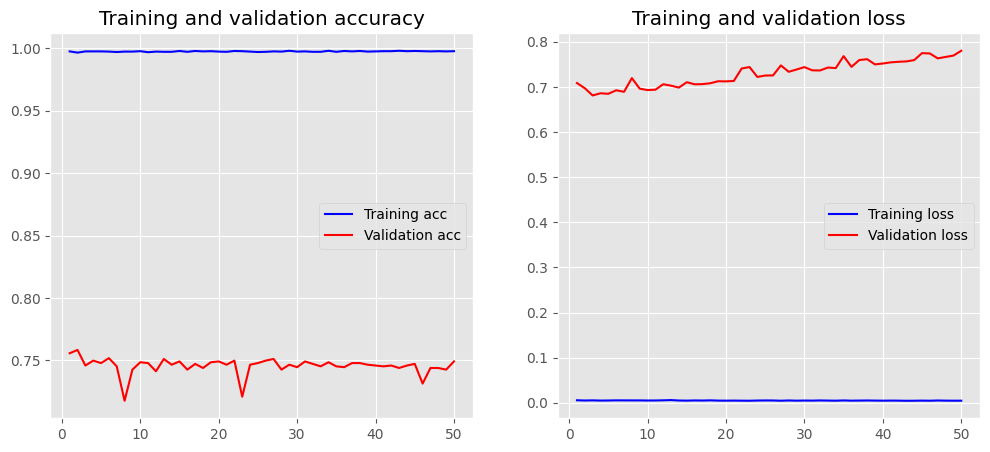

In [362]:
history=keras_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_valid, y_valid))
loss, accuracy = keras_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = keras_model.evaluate(X_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Predict

In [369]:
X_test=new_test_data['text']
X_id=new_test_data['id']

In [370]:
max_length = 100
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [382]:
result_test={
    'id':[],
    'target':[]
}

In [385]:
result=keras_model.predict(X_test)
for i in range(len(result)):
    if result[i]>0.5:
        result_test['target'].append(1)
        result_test['id'].append(X_id[i])
    else:
        result_test['target'].append(0)
        result_test['id'].append(X_id[i])

102/102 [==============================] - 0s 2ms/step


In [387]:
df=pd.DataFrame(result_test)

In [389]:
df.to_csv("result2.csv",index=False)